# exp018_ea
bertとtfidfの類似度の有効性を確認

In [1]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [2]:
exp_name = 'exp018'
memo = 'tfidf'

In [3]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
if MODE == "kaggle_inference":
    from cuml import ForestInference
    import treelite
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_MODEL = "distilbert-base-uncased"
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_MODEL = "../input/distilbertbaseuncased"

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 512
NW = 2
SVD_N_COMP = 50

In [6]:
class Cat2VecModel(nn.Module):
    def __init__(self):
        super(Cat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_MODEL)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def inference(ds):
    cat2vec_model = Cat2VecModel()
    cat2vec_model = cat2vec_model.cuda()
    
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(loader):
            v = cat2vec_model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [7]:
def make_bert_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")

    cat_ds = InferenceDataset(cat_df, max_len=MAX_LEN, col=col)
    V = inference(cat_ds)
    svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return bert_vec

In [8]:
def make_tfidf_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("")

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
    tfidf_vec = tfidf_vectorizer.fit_transform(cat_df[col].tolist())
    svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    tfidf_vec = svd.fit_transform(tfidf_vec)
    tfidf_vec = {k:v for k,v in zip(cat_df[col].values, tfidf_vec)}
    return tfidf_vec

In [9]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    return df

In [10]:
def extract_candidate(df):
    dfs = []
    candidates = pd.DataFrame()
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        dfs.append(country_df[['id','match_id','d_near']])
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [11]:
def add_orgin_data(df, org_df):
    df = df.explode(['match_id','d_near'])
    df = df.loc[df['id'] != df['match_id']].copy()
    df = df.merge(org_df, on='id')
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [12]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [13]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [14]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []

        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_gesh"] = df[f"match_{c}_gesh"].astype(np.float16)
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_leven"] = df[f"match_{c}_leven"].astype(np.float16)
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_jaro"] = df[f"match_{c}_jaro"].astype(np.float16)
        df[f"match_{c}_lcs"] = lcss
        df[f"match_{c}_lcs"] = df[f"match_{c}_lcs"].astype(np.float16)
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"{c}_len"] = df[f"{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[[f"match_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"match_{c}_nleven"] = df[f"match_{c}_nleven"].astype(np.float16)
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_lcs"] / df[f"{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_nlcsi"].astype(np.float16)
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_nlcs0"].astype(np.float16)
            df.drop(f'{c}_len',axis=1, inplace = True)
            df.drop(f"match_{c}_len",axis=1, inplace = True)

    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [15]:
def add_vec_sim_features(df, vec, vec_name, col):
    sim_list = []
    for str1, str2 in tqdm(df[[f"{col}", f"match_{col}"]].values.astype(str)):
        if str1==str1 and str2==str2:
            sim = cosine_similarity(vec[str1].reshape(1, -1), vec[str2].reshape(1, -1))[0][0]
        else:
            sim = -1
        sim_list.append(sim)
    df[f"{vec_name}_sim_{col}"] = sim_list
    df[f"{vec_name}_sim_{col}"] = df[f"{vec_name}_sim_{col}"].astype(np.float16)
    return df

In [16]:
def reduce_data_size(df, features):
    if MODE == 'local_train':
        df = df[features + ['target', 'id', 'match_id']].copy()
    elif MODE == 'kaggle_inference':
        df = df[features + ['id', 'match_id']].copy()


    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
        
    return df

In [17]:
def train_model(df, features):
    params = {'objective': 'binary', 
              'boosting': 'gbdt',
              'learning_rate': 0.1, 
              'metric': 'binary_logloss', 
              'seed': SEED, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.5745709668124809, 
              'lambda_l2': 0.5123383865042099, 
              'num_leaves': 239, 
              'feature_fraction': 0.784, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 5
              }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [18]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        model.save_model("test.lgb")
        fi = ForestInference()
        fi = ForestInference.load("test.lgb", output_class=True, model_type="lightgbm")
        pred += fi.predict(df[features]) / N_SPLITS
    return pred

In [19]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [20]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [21]:
train_origin = pd.read_csv(INPUT_DIR + "train.csv")
train_origin = preprocess(train_origin)

# trainデータの分割
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
    train_origin.loc[val_idx, "set"] = i

# 1st stage
train = pd.concat([
    extract_candidate(train_origin[train_origin["set"]==0]), 
    extract_candidate(train_origin[train_origin["set"]==1]), 
])
train = add_orgin_data(train, train_origin)
stage1_max_score = calc_max_score(train, train_origin)

# 2nd stage
# create target
train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
train["target"] = train["target"].fillna(0)

train = add_distance_features(train)

# reduce memory
train = train.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                            'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                            'match_zip', 'match_country', 'match_url', 'match_phone'])
gc.collect()

# bert類似度
bert_vec_categories = make_bert_vec(train_origin[["categories"]], "categories")
train = add_vec_sim_features(train, bert_vec_categories, "bert", "categories")
del bert_vec_categories
gc.collect()

print("add_bert_sim_name")
bert_vec_name = make_bert_vec(train_origin[["name"]], "name")
train = add_vec_sim_features(train, bert_vec_name, "bert", "name")
del bert_vec_name
gc.collect()

# tfidf類似度
tfidf_vec_categories = make_tfidf_vec(train_origin[["categories"]], "categories")
train = add_vec_sim_features(train, tfidf_vec_categories, "tfidf", "categories")
del tfidf_vec_categories
gc.collect()
tfidf_vec_name = make_tfidf_vec(train_origin[["name"]], "name")
train = add_vec_sim_features(train, tfidf_vec_name, "tfidf", "name")
del tfidf_vec_name
gc.collect()


not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                'match_url_leven', 'state', 'match_phone', 'match_country']
features = [c for c in train.columns if c not in not_use_cols]
with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
    pickle.dump(features, f)

train = reduce_data_size(train, features)

100%|██████████| 211/211 [00:53<00:00,  3.94it/s]


1st_stage_max_score : 0.89040


213it [13:47,  3.89s/it] 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10248613/10248613 [21:01<00:00, 8123.46it/s]


add_bert_sim_name


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10248613/10248613 [20:03<00:00, 8517.04it/s]


In [28]:
train = train.merge(train_origin[["id", "country"]], on="id", how="left")

In [29]:
train["country"].value_counts()

us    2209034
tr    1036621
id     997193
jp     630288
th     529272
       ...   
lr          2
dj          2
pw          2
an          2
eh          2
Name: country, Length: 213, dtype: int64

,d_near,match_name_gesh,match_name_jaro,match_name_lcs,match_name_nleven,match_name_nlcsi,match_name_nlcs0,match_address_gesh,match_address_jaro,match_address_lcs,...,match_id,country,name_x,categories_x,match_name_x,match_categories_x,name_y,categories_y,match_name_y,match_categories_y
8039579,0.000142,0.521973,0.870605,6.0,0.646973,1.000000,0.353027,0.148193,0.458252,2.0,...,E_f131dcb7f07be9,us,togo's sandwiches,sandwich places,togo's,sandwich places,togo's sandwiches,sandwich places,togo's,sandwich places
8039580,0.009514,0.083313,0.407471,1.0,0.944336,0.166626,0.055542,1.000000,1.000000,3.0,...,E_f131dcb7f07be9,us,premier commercial,"coworking spaces, real estate offices",togo's,sandwich places,premier commercial,"coworking spaces, real estate offices",togo's,sandwich places
8039581,0.008675,0.347900,0.642578,4.0,0.823730,0.666504,0.235352,0.250000,0.469971,2.0,...,E_f131dcb7f07be9,us,godfather's pizza,pizza places,togo's,sandwich places,godfather's pizza,pizza places,togo's,sandwich places
8039582,0.003929,0.250000,0.511230,2.0,0.799805,0.333252,0.199951,0.105286,0.465332,1.0,...,E_f131dcb7f07be9,us,saxa gotha,churches,togo's,sandwich places,saxa gotha,churches,togo's,sandwich places
8039583,0.002714,0.285645,0.513672,2.0,1.000000,0.333252,0.250000,1.000000,1.000000,3.0,...,E_f131dcb7f07be9,us,gamestop,video game stores,togo's,sandwich places,gamestop,video game stores,togo's,sandwich places
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10248608,0.008011,0.218140,0.607422,7.0,0.866699,0.700195,0.155518,0.095215,0.462891,1.0,...,E_87d9474cbe0682,us,waimea canyon middle school - faculty parking,parking,inn waimea,hotels,waimea canyon middle school - faculty parking,parking,inn waimea,hotels
10248609,0.001589,0.774414,0.766113,12.0,0.368408,1.000000,0.631348,1.000000,1.000000,3.0,...,E_bd44de7cdd0b2d,us,little micajah pond,lakes,micajah pond,lakes,little micajah pond,lakes,micajah pond,lakes
10248610,0.001806,0.166626,0.513672,4.0,0.852051,0.444336,0.148193,0.076904,0.384766,2.0,...,E_8d45cc569cbbdc,us,dream girls fueling station,gay bars,starbucks,coffee shops,dream girls fueling station,gay bars,starbucks,coffee shops
10248611,0.017929,0.142822,0.361084,1.0,0.875000,0.166626,0.125000,0.263184,0.551758,6.0,...,E_919eb054a8b91a,us,maurices,women's stores,subway,"sandwich places, fast food restaurants, restau...",maurices,women's stores,subway,"sandwich places, fast food restaurants, restau..."


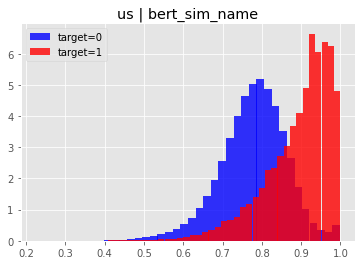

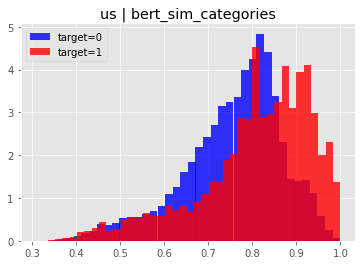

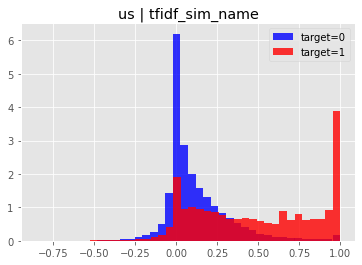

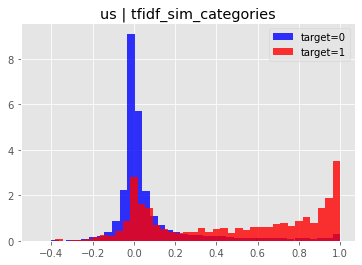

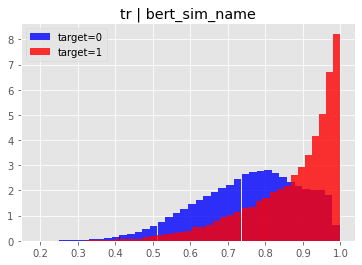

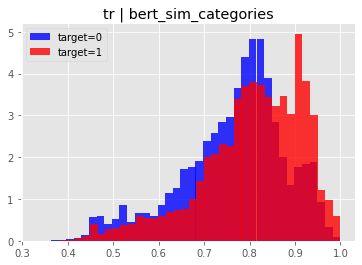

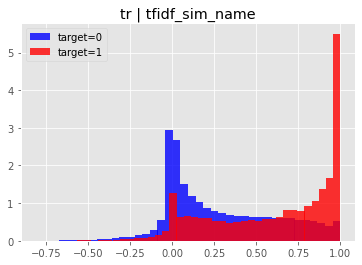

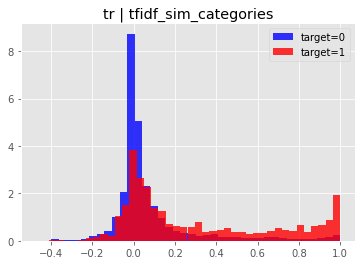

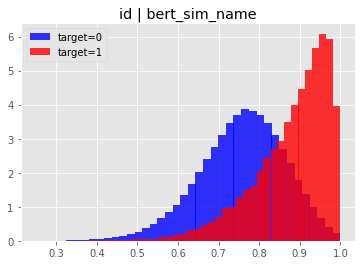

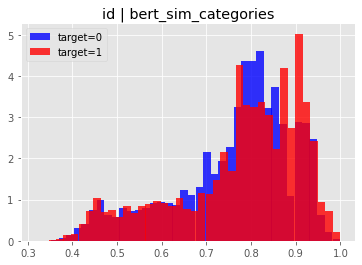

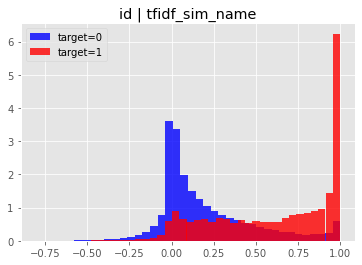

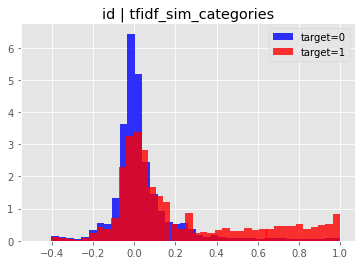

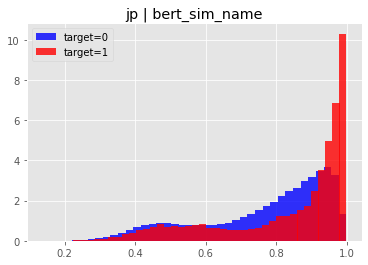

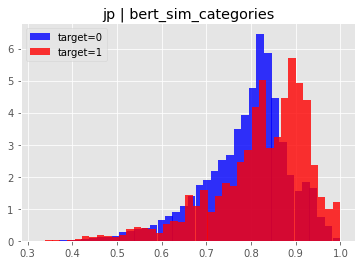

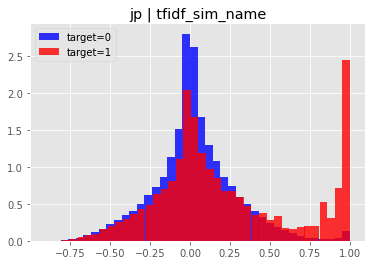

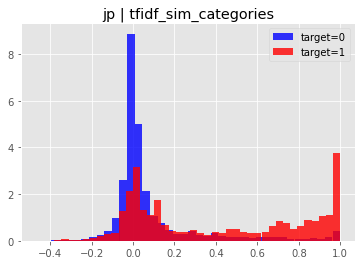

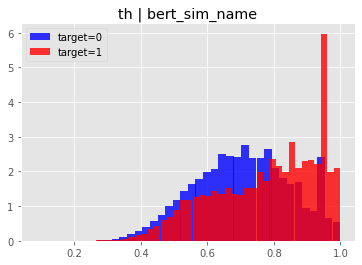

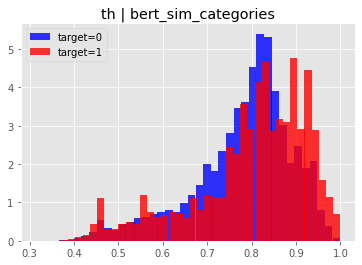

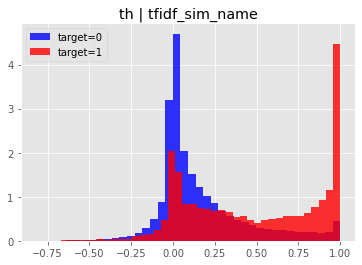

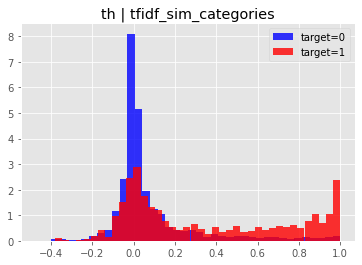

In [84]:
for country in ["us", "tr", "id", "jp", "th"]:
    tmp = train[train["country"]==country].copy()
    for col in ["bert_sim_name", "bert_sim_categories", "tfidf_sim_name", "tfidf_sim_categories"]:
        plt.hist(tmp.loc[(tmp["target"]==0)&(tmp[col]<1), col], color="blue", label="target=0", bins=40, alpha=0.8, density=True)
        plt.hist(tmp.loc[(tmp["target"]==1)&(tmp[col]<1), col], color="red", label="target=1", bins=40, alpha=0.8, density=True)
        plt.legend()
        plt.title(f"{country} | {col}")
        plt.show()

In [43]:
train = train.merge(train_origin[["id", "name", "categories"]], on="id", how="left")
train = train.merge(train_origin[["id", "name", "categories"]].add_prefix("match_"), on="match_id", how="left")

In [72]:
train[(train["country"]=="jp")][["name_x", "match_name_x", "bert_sim_name", "tfidf_sim_name", "target"]].iloc[120:140]

,name_x,match_name_x,bert_sim_name,tfidf_sim_name,target
4333055,doutor coffee zama,上栗原中橋,0.432129,-0.039337,0
4333056,ドトールコーヒーショップ,上栗原中橋,0.706055,-0.032654,0
4333057,中海スカイポート,上栗原中橋,0.825195,0.182251,0
4333058,セリア 三和座間東原店,上栗原中橋,0.924805,-0.115112,0
4333059,ひまわり公園,上栗原中橋,0.875000,0.255615,0
4333060,小田急座間駅 構内女性用御手洗い,上栗原中橋,0.913574,-0.194946,0
4333061,ポニークリーニング 三和座間東原店,上栗原中橋,0.857422,-0.241333,0
4333062,ひまわり公園,上栗原中橋,0.875000,0.255615,0
4333063,上栗原橋,上栗原中橋,0.989258,-0.596191,0
4333064,座間駅 (zama sta.),上栗原中橋,0.718750,0.158691,0


In [76]:
train[(train["country"]=="us")][["name_x", "match_name_x", "bert_sim_name", "tfidf_sim_name", "target"]].iloc[60:80]

,name_x,match_name_x,bert_sim_name,tfidf_sim_name,target
8039639,panera bread,gamestop,0.810547,0.286621,0
8039640,godfather's pizza,gamestop,0.767090,-0.019455,0
8039641,lexington county public safety,gamestop,0.682617,0.034302,0
8039642,gamestop,gamestop,1.000000,1.000000,1
8039643,walmart auto care centers,gamestop,0.699219,0.166870,0
8039644,core chiropractic,gamestop,0.733887,0.002085,0
8039645,core chiropractic,gamestop,0.733887,0.002085,0
8039646,saxe gotha gym,gamestop,0.786133,-0.015305,0
8039647,premier commercial,gamestop,0.916016,0.056488,0
8039648,walmart tires & lube,gamestop,0.695312,0.085266,0


In [77]:
train[(train["country"]=="tr")][["name_x", "match_name_x", "bert_sim_name", "tfidf_sim_name", "target"]].iloc[0:20]

,name_x,match_name_x,bert_sim_name,tfidf_sim_name,target
7002958,turkcell,yengenin yeri,0.851562,0.355469,0
7002959,tığ ekmek,yengenin yeri,0.910645,0.744629,0
7002960,sarıoğlu apartmanı,yengenin yeri,0.890625,-0.002176,0
7002961,anker travel,yengenin yeri,0.690430,-0.109192,0
7002962,aydın kadın doğum ve çocuk hastalıkları hastanesi,yengenin yeri,0.870117,0.434082,0
7002963,uysal 03 hafriyat i̇nşaat ofis,yengenin yeri,0.705078,0.416260,0
7002964,red çay ocağı,yengenin yeri,0.884277,0.442383,0
7002965,aydin 09 haber,yengenin yeri,0.770996,0.366455,0
7002966,anbarlı apartmanı,yengenin yeri,0.895020,-0.002262,0
7002967,büffe büfe,yengenin yeri,0.668945,0.232178,0
